# Manually Parse ATL06 for troubleshooting  

Error in parser could be due not passing the logger when the function expects one  
logging.basicConfig(filename=f'logs_{region}.log', level=logging.INFO, format='%(asctime)s:%(levelname)s:%(message)s')

Sometimes one or more of ground_tracks may not have data [ie, lat, lon, h_li etc] but the hdf file still there  
One or more of the ground-tracks can have missing data

In [1]:
%matplotlib inline

In [2]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (15, 8), 'font.size': 10})

from shapely.geometry import Polygon, Point

import contextily as ctx
import h5py

In [3]:
from icesat2_download import gps2dyr
from icesat2_download import  move_files_from_order, read_atl06, read_atl08, read_atl03, get_api_key


---

In [4]:
# icesat2_path = 'D:/wspace/icesat2/alaska'
# icesat2_path = f'/fs/project/howat.4/yadav.111/icesat2/greenland'
# icesat2_path = 'test_data'
# icesat2_path = 'D:/icesat2/cordillera_ATL06'
# icesat2_path = f'/fs/project/howat.4/icesat2/ArcticDEM/region_06_greenland_northwest/W1W2_20190330_1020010084689400_103001008D7E2800_2m_lsf_v040002'
# icesat2_path = f'/fs/project/howat.4/icesat2/mcmurdo_ATL06'
icesat2_path = f'/fs/project/howat.4/icesat2/antarctica_ATL06/rema_04_ronne_shelf'

os.listdir(icesat2_path)

['downloads',
 'outline.shp',
 'outline.shx',
 'outline.dbf',
 'outline.cpg',
 'outline.prj']

In [5]:
# base_icesat2_path = f'/fs/project/howat.4/icesat2/antarctica_{short_name}/{region}' # Get path to folder with downloaded IS2 files
# strips = os.listdir(icesat2_path)
# [s for s in strips if s.endswith('.shp')]

In [6]:
# outline = gpd.read_file(f'{icesat2_path}/strip_outline.shp')
outline = gpd.read_file(f'{icesat2_path}/outline.shp')
# outline.crs = {'init': 'epsg:4326'} #somehow proj file was missing here (this should not happen in future)
outline

region      Area   Perim  \
0  rema_04_ronne_shelf  494773.0  5918.0   

                                            geometry  
0  MULTIPOLYGON (((-78.30422 -79.85386, -78.21166...

In [7]:
outline.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

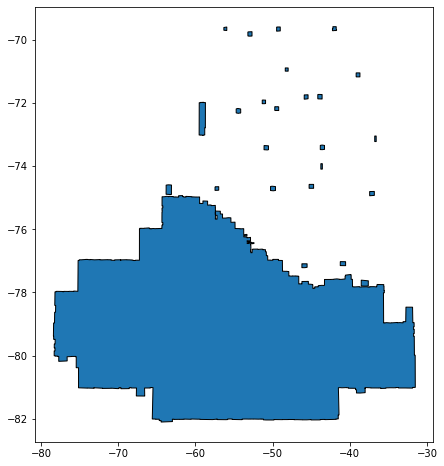

In [8]:
outline.plot(facecolor=None, edgecolor='k');

In [9]:
type(outline)

geopandas.geodataframe.GeoDataFrame

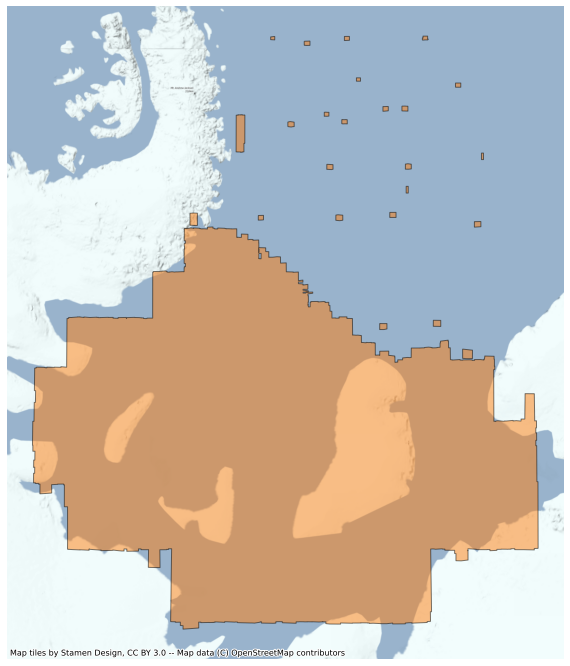

In [10]:
# outline = outline.to_crs(epsg=3857) #convert to web-mercator for visualization
fig, ax = plt.subplots(figsize=(11,12))
# ax = outline.to_crs(epsg=3857).plot(alpha=.5)
outline.to_crs(epsg=3857).plot(facecolor='C1', edgecolor='k', alpha=.5, ax=ax) # convert to web-mercator to use contextly
# https://geopandas.org/gallery/plotting_basemap_background.html
# ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)
ctx.add_basemap(ax=ax) # Also provide zoom=12
ax.set_axis_off()

In [14]:
# import geoplot
icesat2_path

'/fs/project/howat.4/icesat2/antarctica_ATL06/rema_04_ronne_shelf'

In [15]:
# move the hdf files to base folder and deleted the "downloads" folder
move_files_from_order(icesat2_path)

In [18]:
# If automated parser required
short_name = 'ATL06'
if short_name == 'ATL08':
    print(f'Parsing {short_name} hdf file')
    read_atl08(icesat2_path) #gis_output='gpkg'
if short_name == 'ATL06':
    print(f'Parsing {short_name} hdf file')
    read_atl06(icesat2_path) 
print('Done')


Parsing ATL06 hdf file
Done


In [12]:
# def read_atl06(icesat2_path):
""" 
Read 1 ATL06 file and output 6 reduced files. 

Extract variables of interest and separate the ATL06 file 
into each beam (ground track) and ascending/descending orbits.
"""
files = os.listdir(f'{icesat2_path}')
# files
hdf_files = [f for f in files if f.endswith('.h5') and 'ATL06' in f]#[f for f in files if f.endswith('.h5')]
hdf_files

[]

In [12]:
shp_files = [f for f in files if f.endswith('.gpkg') and 'ATL06' in f]#[f for f in files if f.endswith('.h5')]
shp_files

['processed_ATL06_20200510054338_06820712_003_01.gpkg',
 'processed_ATL06_20200521163056_08570710_003_01.gpkg']

In [17]:

hdf_files = list(set([f.split('.')[0] for f in hdf_files]) - set([f.split('.')[0] for f in shp_files]))
hdf_files

['processed_ATL06_20200525162235_09180710_003_01',
 'processed_ATL06_20200612041117_11850712_003_01',
 'processed_ATL06_20200623145836_13600710_003_01',
 'processed_ATL06_20200707025538_01790812_003_01',
 'processed_ATL06_20200608041938_11240712_003_01']

In [29]:
# for f in hdf_files[5:6]:
f = hdf_files[2]
hdf_path = f'{icesat2_path}/{f}.h5'
print(f'{hdf_path} {os.path.exists(hdf_path)}')
res_dict = {}
meta_dict = {} #These will hold metadata required for scalars per ground-track
# group = ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
# group = ['gt2l', 'gt2r', 'gt3l', 'gt3r']
# group = ['gt1l', 'gt1r']
group = ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
# Loop trough beams
# Perhaps read file first, then loop through groups; should be faster


test_data/processed_ATL06_20200623145836_13600710_003_01.h5 True


In [30]:
fi = h5py.File(hdf_path, 'r')

In [31]:
# [g for g in list(fi.keys()) if g in group]

In [32]:
g ='gt1l'
# fi[f'/{g}/residual_histogram/dh'][:]
fi[f'/{g}/'].keys()

<KeysViewHDF5 ['land_ice_segments', 'residual_histogram', 'segment_quality']>

In [33]:
# subset group based on data
group = [g for g in list(fi.keys()) if g in group]
for k,g in enumerate(group):
    try:
        print(k, g)
        # 1) Read in data for a single beam #
        lat = fi[f'/{g}/land_ice_segments/latitude'][:]
        lon = fi[f'/{g}/land_ice_segments/longitude'][:]
        h_li = fi[f'/{g}/land_ice_segments/h_li'][:] #nan
    except:
        print('Exception: ', k, g)

0 gt1l
1 gt1r
2 gt2l
3 gt2r
4 gt3l
5 gt3r


In [34]:
res_dict = {}
meta_dict = {} #These will hold metadata required for scalars per ground-track
group = ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
qual_str_count = ''
# Loop trough beams
# Perhaps read file first, then loop through groups; should be faster
# with h5py.File(hdf_path, 'r') as fi:
fi = h5py.File(hdf_path, 'r')

In [35]:
fi.keys()

<KeysViewHDF5 ['METADATA', 'ancillary_data', 'gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r', 'orbit_info', 'quality_assessment']>

In [36]:
# subset group based on data
group = [g for g in list(fi.keys()) if g in group]
group1 = len(group)
group1

6

In [37]:
group = [g for g in group if 'land_ice_segments' in fi[f'/{g}']]
group2 = len(group)
group2

6

In [38]:
if group2<group1:
    print(f'Non-empty groups: {group2}/{group1}')
# NB: Assert if at least one group present else may be error due to enumeration
if len(group) == 0:
    print('No any Group!')
    #continue #End parsing here, because nothing to parse
    

In [39]:
print(group)

['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']


In [40]:
for k,g in enumerate(group):
    lat = fi[f'/{g}/land_ice_segments/latitude']
    lon = fi[f'/{g}/land_ice_segments/longitude']
    h_li = fi[f'/{g}/land_ice_segments/h_li']
    #s_li = fi[f'/{g}/land_ice_segments/h_li_sigma']
    t_dt = fi[f'/{g}/land_ice_segments/delta_time']
    q_flag = fi[f'/{g}/land_ice_segments/atl06_quality_summary']
    t_ref = fi['/ancillary_data/atlas_sdp_gps_epoch'][:] #scalar 1 value; required for offset

    meta_dict['t_ref'] = t_ref #dictionary of metadata (will be used in future to investigate data)
    df = pd.DataFrame({'lon':lon, 'lat':lat, 'h_li': h_li, 'q_flag':q_flag, 't_dt':t_dt})
    #Convert GPS time to actual time using function
    df['t_dt'] = df['t_dt'].apply(gps2dyr, offset=t_ref[0])
    df.loc[df.h_li>3e38, 'h_li'] = np.nan
    df = df.dropna()
    all_points = len(df)
    good_quality_points = len(df) #len(df[df.q_flag==0])
    qual_str_count = qual_str_count + f'{g}={good_quality_points}/{all_points}; '
    if len(df)>0:
        res_dict[g] = df

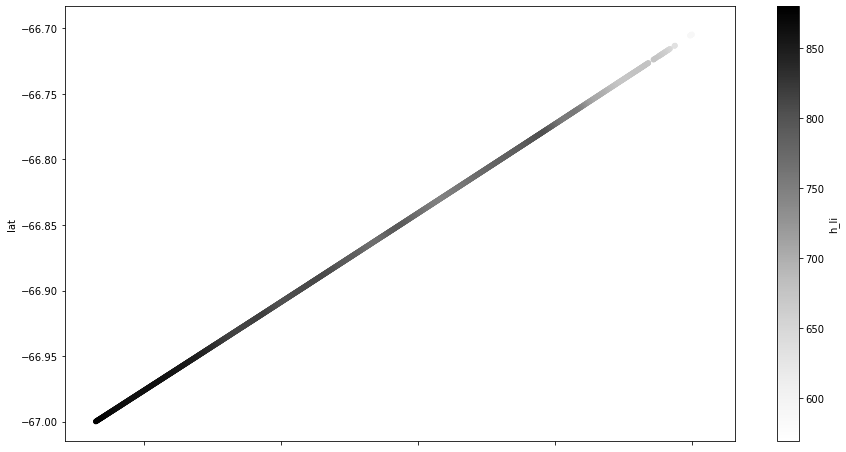

In [41]:
df.plot.scatter(x='lon', y='lat', c='h_li');

In [42]:
#----------------------------------------------------------------------------------------------
# Now that ATL06 data from separate ground tracks are in one dict, merge it to df and save to csv/shp
if len(res_dict)>0:
    count = 0
    for k in res_dict.keys():
        if count == 0:
            df = res_dict[k]
            df['strip'] = k
            count += 1
        else:
            df1 = res_dict[k]
            df1['strip'] = k
            df = pd.concat([df, df1], axis=0)


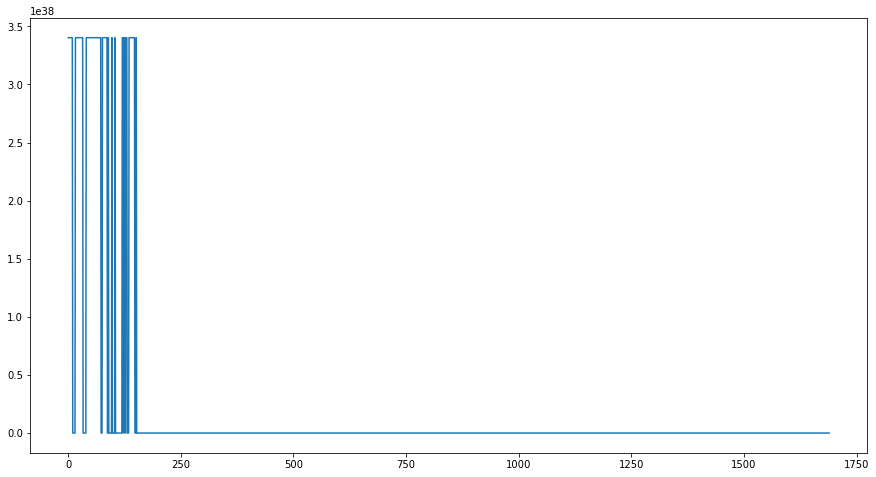

In [43]:
# h_li[h_li>3e38] = np.nan
plt.plot(h_li)

NameError: name 'gdf' is not defined

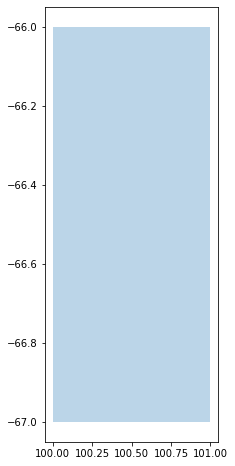

In [44]:
ax = outline.plot(alpha=.3)
gdf.plot(column='strip', legend=True, ax=ax);

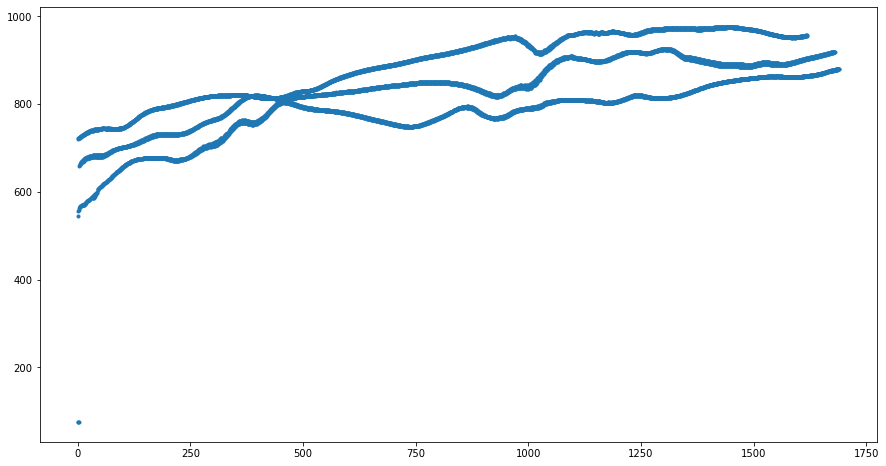

In [45]:
df.h_li.plot(style='.');

In [46]:
import hvplot
import hvplot.pandas
import geoviews as gv

In [47]:
df.head(2)

lon        lat        h_li  q_flag                    t_dt strip
0  100.492680 -66.712852  721.055542       0 2020-06-23 15:03:37.946  gt1l
1  100.492632 -66.713030  722.135925       0 2020-06-23 15:03:37.949  gt1l

In [48]:
df.hvplot(y='h_li', x='t_dt', by='strip', kind='scatter')

:NdOverlay   [strip]
   :Scatter   [t_dt]   (h_li)

In [49]:
# gv.tile_sources.StamenTerrainRetina 
(gv.tile_sources.ESRI  * df.hvplot.points('lon', 'lat', geo=True, color='strip', alpha=0.6, width=500, height=800, hover=['strip', 'h_li']) + 
 df.hvplot(y='lat', x='h_li', by='q_flag', kind='scatter', height=800, alpha=.7)).cols(2)

:Layout
   .Overlay.I   :Overlay
      .WMTS.I   :WMTS   [Longitude,Latitude]
      .Points.I :Points   [lon,lat]   (strip)
   .NdOverlay.I :NdOverlay   [q_flag]
      :Scatter   [h_li]   (lat)

In [50]:
# outline.plot()

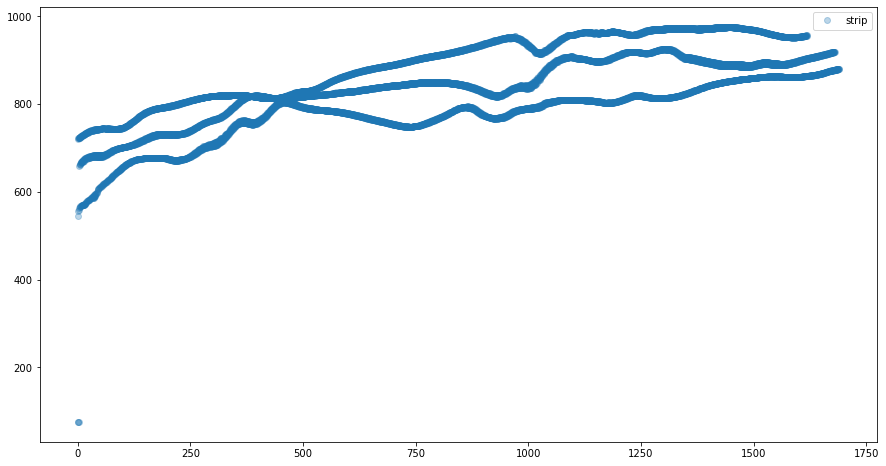

In [51]:
df.h_li.plot(style='o', label='strip', alpha=.3)
plt.legend(loc=0)

In [52]:
import holoviews as hv

In [53]:
points = hv.Points(np.random.randn(500,2))
points.hist(num_bins=51, dimension=['x','y'])

:AdjointLayout
   :Points   [x,y]
   :Histogram   [y]   (y_frequency)
   :Histogram   [x]   (x_frequency)

In [54]:
t_diff = df.t_dt.max() - df.t_dt.min()
t_diff

Timedelta('0 days 00:00:09.417000')

In [55]:
# How many minutes worth of data in the granule
t_diff.total_seconds()/60

0.15695

In [56]:
# df.to_csv('C:/temp/del.csv', index=False)

In [57]:
shp_files = [f for f in files if f.endswith('.gpkg') and 'ATL06' in f]
shp_files

['processed_ATL06_20200510054338_06820712_003_01.gpkg',
 'processed_ATL06_20200521163056_08570710_003_01.gpkg']

In [58]:
shp1 = f'{icesat2_path}/{shp_files[0]}'

In [59]:
gdf = gpd.read_file(shp1)

In [60]:
gdf['t_dt'] = pd.to_datetime(gdf.t_dt)

In [61]:
gdf.head()

t_dt        h_li  q_flag strip  \
0 2020-05-10 05:47:26.547001+00:00  998.527588       0  gt1l   
1 2020-05-10 05:47:26.549999+00:00  997.953918       0  gt1l   
2 2020-05-10 05:47:26.552999+00:00  997.582947       0  gt1l   
3 2020-05-10 05:47:26.555000+00:00  997.110962       0  gt1l   
4 2020-05-10 05:47:26.558001+00:00  996.926941       0  gt1l   

                      geometry  
0  POINT (100.50695 -66.99998)  
1  POINT (100.50690 -66.99980)  
2  POINT (100.50685 -66.99963)  
3  POINT (100.50680 -66.99945)  
4  POINT (100.50674 -66.99927)

<AxesSubplot:>

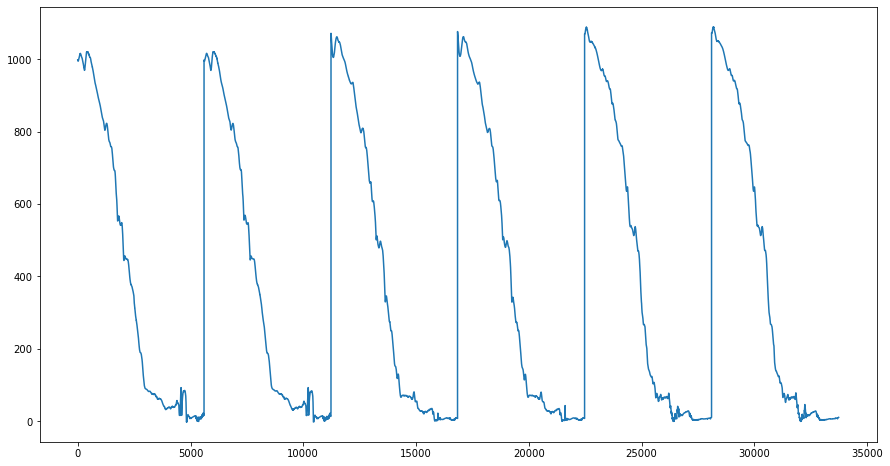

In [62]:
gdf[gdf.q_flag==0].h_li.plot()
# gdf[gdf.q_flag==1].h_li.plot(style='o')

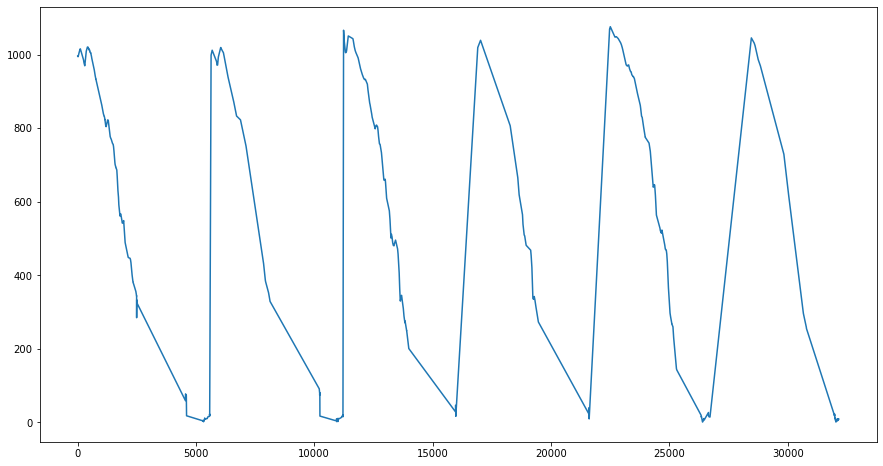

In [63]:
gdf[gdf.q_flag==1].h_li.plot();

In [64]:
df

lon        lat        h_li  q_flag                    t_dt strip
0     100.492680 -66.712852  721.055542       0 2020-06-23 15:03:37.946  gt1l
1     100.492632 -66.713030  722.135925       0 2020-06-23 15:03:37.949  gt1l
2     100.492584 -66.713207  722.945374       0 2020-06-23 15:03:37.951  gt1l
3     100.492535 -66.713385  723.689331       0 2020-06-23 15:03:37.954  gt1l
4     100.492487 -66.713563  724.444519       0 2020-06-23 15:03:37.957  gt1l
...          ...        ...         ...     ...                     ...   ...
1685  100.253158 -66.999162  878.677063       0 2020-06-23 15:03:42.929  gt3r
1686  100.253107 -66.999340  878.997131       0 2020-06-23 15:03:42.932  gt3r
1687  100.253055 -66.999517  879.288818       0 2020-06-23 15:03:42.935  gt3r
1688  100.253003 -66.999695  879.464905       0 2020-06-23 15:03:42.938  gt3r
1689  100.252952 -66.999872  879.665649       0 2020-06-23 15:03:42.941  gt3r

[9849 rows x 6 columns]

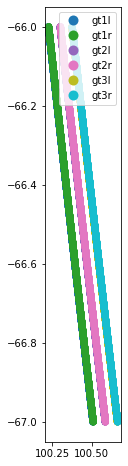

In [65]:
# js = gdf.to_json()
gdf.plot(column='strip', legend=True);